In [1]:
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import lxml
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../files/df_a_usar_2.csv', index_col=0)
df.sample(3)

,index,time,age,gender,country_q3,education_q4,role_q5,experience_q6,Q8,Q11,...,Q38_B_Part_3,Q38_B_Part_4,Q38_B_Part_5,Q38_B_Part_6,Q38_B_Part_7,Q38_B_Part_8,Q38_B_Part_9,Q38_B_Part_10,Q38_B_Part_11,Q38_B_OTHER
14215,14215,322,22-24,Man,India,Bachelor’s degree,Student,3-5 years,Python,A laptop,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15314,15314,780,35-39,Woman,Russia,No formal education past high school,Student,< 1 years,Javascript,A laptop,...,NaN,NaN,TensorBoard,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25392,25392,455,25-29,Man,Russia,Bachelor’s degree,Data Scientist,3-5 years,Python,A personal computer / desktop,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
gender = (df['gender'].value_counts()).reset_index()
gender

,index,gender
0,Man,20598
1,Woman,4890
2,Prefer not to say,355
3,Nonbinary,88
4,Prefer to self-describe,42


In [5]:
gender['index']

0                        Man
1                      Woman
2          Prefer not to say
3                  Nonbinary
4    Prefer to self-describe
Name: index, dtype: object

In [6]:
df['role_q5'].value_counts()

Student                         6804
Data Scientist                  3616
Software Engineer               2449
Other                           2393
Data Analyst                    2301
Currently not employed          1986
Research Scientist              1538
Machine Learning Engineer       1499
Business Analyst                 968
Program/Project Manager          849
Data Engineer                    668
Product Manager                  319
Statistician                     313
DBA/Database Engineer            171
Developer Relations/Advocacy      99
Name: role_q5, dtype: int64

#### Depuración de la categoría 'gender':

Observamos 5 categorías, siendo 2 hombre y mujer (géneros binarios), estando las 3 restantes dedicadas a aquellas personas que no se encuentran en el marco binario del género o prefieren no reportar su identidad de género.

Tras consultar a la comunidad científica, [como es el caso de esta guía orientada a la investigación HCI (Human-Computer Interaction (2019)](https://sci-hub.hkvisa.net/10.1145/3338283), optamos por fusionar las categorías 'Nonbinary' y 'Prefer to self-describe'.

In [7]:
df['gender2'] = df['gender'].replace({'Man': 'Hombre', 'Woman': 'Mujer', 'Prefer to self-describe': 'NB', 'Nonbinary': 'NB', 'Prefer not to say': np.nan})
df['gender2'].value_counts()

Hombre    20598
Mujer      4890
NB          130
Name: gender2, dtype: int64

#### Tabla de contingencias

Género x Puesto

In [8]:
tab_conting = pd.crosstab(df['role_q5'], df['gender2'], margins=False)
tab_conting

gender2,Hombre,Mujer,NB
role_q5,,,
Business Analyst,779,175,4
Currently not employed,1479,463,15
DBA/Database Engineer,141,20,1
Data Analyst,1759,505,9
Data Engineer,561,98,2
Data Scientist,2971,584,16
Developer Relations/Advocacy,79,16,2
Machine Learning Engineer,1285,179,10
Other,1926,429,12


Cálculo de las frecuencias relativas con % verticales (distribución por género):

In [9]:
#https://stackoverflow.com/a/21247312
per_tab_conting = pd.crosstab(df['role_q5'], df['gender2'], margins=False).apply(lambda x: round(x/x.sum(), 2), axis=0)
per_tab_conting

gender2,Hombre,Mujer,NB
role_q5,,,
Business Analyst,0.04,0.04,0.03
Currently not employed,0.07,0.09,0.12
DBA/Database Engineer,0.01,0.00,0.01
Data Analyst,0.09,0.10,0.07
Data Engineer,0.03,0.02,0.02
Data Scientist,0.14,0.12,0.12
Developer Relations/Advocacy,0.00,0.00,0.02
Machine Learning Engineer,0.06,0.04,0.08
Other,0.09,0.09,0.09


#### **Interpretación inicial de las frecuencias relativas**:

Se optan por los porcentajes de columna dado que los hombres cuadriplican a las mujeres, distorsionando los resultados de los % de género por cada puesto. En los próximos pasos de la investigación, sería necesario ponderar los casos.


- En la muestra predominan lxs estudiantes: Más de un cuarto de las mujeres de la muestra (32%) son estudiantes, seguidas de las personas no binarias (28%) y hombres (25%).

- Entre las categorías más frecuentes, independientemente del género, se encuentra el rol de Data Scientist: El 14% de los hombres desempeñan este rol, y en el caso de las mujeres y personas NB un 12%.

- Existen también diferencias según el género:
    - El 10% de los hombres desempeñan el rol de ingenieros de software.
    - El 10% de las mujeres son analistas de datos.
    - El 12% de las personas NB encuestadas están actualmente en situación de desempleo.

### **Representaciones gráficas:**

#### - Género:

In [10]:
gender2 = (df['gender2'].value_counts()).reset_index()
gender2

,index,gender2
0,Hombre,20598
1,Mujer,4890
2,NB,130


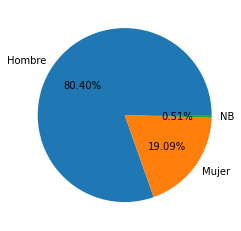

In [12]:
plt.figure()
plt.pie(gender2['gender2'], labels=gender2['index'], autopct='%1.2f%%')
plt.show();

#### - Puesto:

[PENDIENTE]

<Figure size 432x288 with 0 Axes>

#### - Representación gráfica de la distribución de la muestra según el género y el puesto:

[PENDIENTE]

#### Aproximación a la correlación entre género y puesto:

#### Cálculo de la correlación:

Vamos a calcular la correlación entre género y puesto. Para ello haremos las siguientes operaciones:
- Chi cuadrado (al tratarse de dos variables categóricas)
- Cálculo de residuos para comprobar en qué género(s) existe una relación con el puesto.

In [14]:
from scipy.stats import chi2_contingency

In [15]:
#https://thinkingneuron.com/how-to-measure-the-correlation-between-two-categorical-variables-in-python/
chi2 = chi2_contingency(tab_conting)
if chi2[1] <= .05:
    print(f"Existen diferencias significativas en el tipo de puesto según el género, con una p de {round(chi2[1], 2)}")
else:
    print(f"No existen diferencias significativas en el tipo de puesto según el género, con una p de {round(chi2[1], 2)}")

Existen diferencias significativas en el tipo de puesto según el género, con una p de 0.0
